In [1]:
#instantiate and load overlay
from pynq import Overlay

#note the .bit file must have the same name as the .hwh and .tcl file
adc_interface = Overlay("adc_interface.bit")

In [2]:
#verify that overlay is loaded
print(adc_interface.is_loaded())

True


In [3]:
#print address mapped modules present in overlay (optional)
print(adc_interface.ip_dict.keys())

dict_keys(['axi_registers', 'processing_system7_0'])


In [4]:
#create an alias for the axi_registers module
axi_port = adc_interface.axi_registers

In [5]:
"""
The axi registers module contains the following registers witht the following bits:

Address 0 (read-only):
    heartbeat_counter - This register increments every clock cycle to indicate operation of the PL with the following
                        bits:
        heartbeat_counter[31:0] - heartbeat counter value. This value increments every clock cycle on the PL clock
                                  domain.

Address 1 (read-only):
    adc_test_data - This register contains the data output from the XADC module connected to the DAQ module. This
                    can be used to read data directly from the ADC without using the DAQ FIFO to buffer data. This
                    value represents measurements from the V_P and V_N inputs. This register uses the following bits:
        adc_test_data[15:0] - output data from XADC module connected to DAQ module
        adc_test_data[31:16] - unused

Address 2 (read-only):
    adc_valid_counter - This register increments every time a valid signal is recieved from the XADC axi-stream port.
                        This can be used to confirm operation of the XADC output data port. The following bits are used:
        adc_valid_counter[31:0] - adc valid counter value. This value is incremented when the DAQ XADC module axi-stream
                                  valid signal is asserted.
    
Address 3 (read-only):
    adc_busy_counter - This register increments every time the DAQ XADC module busy_out signal is asserted. This can be
                       used to confirm that the XADC module is successfully performing analog-to-digital conversions.
                       This register uses the following bits
       adc_busy_counter[31:0] - adc busy counter value. This value is incremented when the DAQ XADC module busy_out
                                signal is asserted.

Address 4 (read-only):
    daq_status_reg  - The general status of the daq is communicated via the following bits in the daq_status_reg:
        daq_status_reg[15:0] - daq_event_counter incremented every time an event is recorded
        daq_status_reg[16]   - threshold flag that is set if the adc value is triggering the daq (exceeding the 
                               threshold in the positive or negative direction as defined by bits  13 and 11:0 in the 
                               daq_control_register), this bit will clear as soon as the adc value is no longer 
                               triggering the daq
        daq_status_reg[17]   - threshold flag sticky bit that is set if the adc value triggers the daq and only cleared 
                               by the user via the daq_control_reg
        daq_status_reg[18]   - fifo empty
        daq_status_reg[19]   - fifo full
        daq_status_reg[20]   - fifo_data_req_ack, this signal is set when the output fifo data is  updated following a
                               new data req from the PS

Address 5 (read-only):
    daq_fifo_data_reg - This register contains data read from the DAQ FIFO. Data can be loaded
                        into this register via a PS-PL handshake performed using the daq_control_reg
                        and the daq_status_reg. The following bits are used:
        daq_fifo_data_reg[31:0] - The latest data value read from the DAQ FIFO.
                               
Address 128 (write/read):
    daq_control_reg - The general operation of the DAQ is controlled by the following bits in the daq_control_reg
                      (only 1 for now):
                      
        daq_control_reg[11:0] - adc threshold value in twos-compliment. This controls which values above or below which 
                                the data from the adc is considered valid
        daq_control_reg[12]   - adc threshold write enable, when set, the threshold value from this register will be 
                                written into the daq threshold regisgers                        
        daq_control_reg[13]   - this controls whether valid data is above or below the threshold 0 indicates that data
                                must be above the threshold, while 1 indicates that it must be below the threshold.
        daq_control_reg[14]   - threshold direction write enable, when set the value from                      
        daq_control_reg[15]   - Setting this bit will clear all sticky bits in the daq_status_register
        daq_control_reg[16]   - Setting this bit will reset the trigger counter in the daq_status_register
        daq_control_reg[17]   - fifo_reset, setting this bit will reset the data fifo (i.e. reset write and read 
                                pointers)
        daq_control_reg[18]   - fifo_data_req, this bit is set by the PS when it wants to load a new value from the fifo 
                                into fifo_data_reg
        daq_control_reg[19]   - fifo_data_ack, this bit is set to indicate the PS has read the value currently held in 
                                the fifo_data_reg
"""

#readout entire 8-bit address space and print values
for addr in range(0,255):
    read_value = axi_port.read(addr*4)
    print('value read from address ' + str(addr) + ' is the following: ' + bin(read_value))

value read from address 0 is the following: 0b110010001110101110111110000001
value read from address 1 is the following: 0b1111111111100010
value read from address 2 is the following: 0b11110111011011001011011
value read from address 3 is the following: 0b11110111011011110001100
value read from address 4 is the following: 0b10101001010100011001
value read from address 5 is the following: 0b0
value read from address 6 is the following: 0b0
value read from address 7 is the following: 0b0
value read from address 8 is the following: 0b0
value read from address 9 is the following: 0b0
value read from address 10 is the following: 0b0
value read from address 11 is the following: 0b0
value read from address 12 is the following: 0b0
value read from address 13 is the following: 0b0
value read from address 14 is the following: 0b0
value read from address 15 is the following: 0b0
value read from address 16 is the following: 0b0
value read from address 17 is the following: 0b0
value read from addre

In [6]:
#declare some functions to help control and read data from the DAQ in the PL

import matplotlib.pyplot as plt
import matplotlib as mpl
import time

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val                         # return positive value as is


def write_daq_threshold(threshold, direction):
    """
    This function assign a threshold and a threshold direction to the daq_control_register and set write-enable bits.
    threshold - is 12-bit two's complement value compared to the current DAQ ADC value and used to trigger
                the DAQ. When triggered, the DAQ will set the threshold flag, increment the event counter,
                and save adc values to the FIFO.
    direction - is a single-bit value indicating whether the ADC value must be greater than or less than the 
                threshold value to trigger the DAQ
    """
    axi_port.write(128*4, (1 << 14)|((direction) << 13)| (1 << 12) | (threshold & 0b111111111111))
    
def clear_daq_sticky_bits():
    """
    This function clears the threshold flag sticky bit in the daq_status_reg by setting the clear_sticky_bits bit
    in the daq_control_reg
    """
    axi_port.write(128*4, (1 << 15))
    axi_port.write(128*4, (0 << 15))
    
def clear_daq_event_counter():
    """
    This function clears the daq event counter in the daq_status_reg by setting the reset trigger counter bit in
    the daq_control_reg
    """
    axi_port.write(128*4, (1 << 16))
    axi_port.write(128*4, (0 << 16))

def reset_daq_fifo():
    """
    This function resets the FIFO (i.e. clears existing data by resetting write and read pointers) by setting the
    reset fifo bit in the daq_control_reg
    """
    axi_port.write(128*4, (1 << 17))
    axi_port.write(128*4, (0 << 17))
    
def is_fifo_empty():
    """
    This funciton checks if the DAQ fifo is empty by reading the fifo empty signal from the daq_status_reg.
    Returns True if the FIFO is empty, False otherwise
    """
    #read daq_status_reg
    addr = 4
    daq_status_reg_value = axi_port.read(4*addr)
    #check if bit 18 is set
    if (daq_status_reg_value & (1 << 18)) == 0:
        return False
    else:
        return True

def read_next_fifo_value():
    """
    This function reads the next value from the DAQ FIFO. This utilizes the following sequence to request new data,
    read new data, and complete the PS-PL handshake:
        1. The PS sets the fifo_data_req signals and clears the fifo_data_ack signal to request a new value from the FIFO
        2. The PL reads the next value from the FIFO, assigns it to the fifo_data_reg, and sets the fifo_req_ack signal
           to indicate that the requested FIFO value has been written to the fifo_data_reg
        3. The PS reads the fifo_data_reg, clears the fifo_data_req signal, and asserts the fifo_data_ack signal to indicate
           that the new FIFO value has been read from the fifo_data_reg
        4. The PL clears the fifo_req_ack bit
        5. The PS clears the fifo_data_ack bit
    The PL will not write a new value to the fifo_data_reg until the previous handshake has been completed and a new value is
    requested by the PS.
    
    Once a new value is read, the function returns it. If no value can be read, a None type is returned
    """
    #make sure FIFO isn't empty, else read the next value from the FIFO using the handshake protocol
    if is_fifo_empty():
        #print('no new data to read, returning none!')
        return None
    else:
        #request data from fifo by asserting the data_req bit (bit 18) in the daq_control_reg (addr 128)
        axi_port.write(128*4, (0 << 19)|(1 << 18))
        #wait for the data_req_ack bit to get set in the daq_status_reg (bit 20 addr 4), this should basically be immediate 
        while ((axi_port.read(4*4) & (1 << 20)) == 0):
            pass
        #once the data_req_ack bit is set, read the value from the daq_fifo_data_reg (addr 5)
        next_fifo_value = axi_port.read(5*4)
        #print('next value read from fifo: ' + str(next_fifo_value))
        #clear the data_req bit and set the data_ack bit (bit 19 of addr 128)
        axi_port.write(128*4, (1 << 19)|(0 << 18))
        #wait for the data_req_ack bit to clear
        while (not ((axi_port.read(4*4) & (1 << 20)) == 0)):
            pass
        #clear the data_ack bit
        axi_port.write(128*4, (1 << 19)|(0 << 18))
        #return the new fifo value
        return next_fifo_value
    
def drain_fifo():
    """
    This function reads all data in the FIFO into a list and returns the list.
    If no data was in the FIFO, the returned list will contain a single None-type
    """
    new_data = read_next_fifo_value()
    fifo_data = []
    n_fifo_data_points = 0
    while (not(new_data == None)):
        fifo_data.append(new_data)
        new_data = read_next_fifo_value()
        n_fifo_data_points += 1
    print('retrieved ' + str(n_fifo_data_points) + ' data points from the FIFO!')
    return fifo_data

def plot_fifo_data():
    """
    This function drains the FIFO and creates and saves a scatter plot of the data. The plotted data is then
    returned as a list
    """
    fifo_data = drain_fifo()
    n_data_points = len(fifo_data)
    x_values = []
    if n_data_points == 0:
        print('FIFO is empty, no data to plot.')
    else:
        #convert to 2's compliment
        for i in range(0, n_data_points):
            x_values.append(i)
            fifo_data[i] = twos_comp(fifo_data[i], 12)
        plt.figure(1)
        plt.scatter(x_values,fifo_data)
        plt.savefig('plots/fifo_data_' + str(time.time()) + '.png')
        plt.show()
    return fifo_data

In [13]:
#declare functions to run fixed event-count and fixed time interval experiments

import numpy as np
import time

def fixed_event_count_experiment(n_events = 100, threshold=0b111111100111, threshold_direction=1):
    """
    This function will run an experiment until it has accumulated a fixed number of events. An event is
    defined as the number of times the FIFO has to drain. This assumes that events will be spaced sufficiently
    apart that there will be ample time to drain the FIFO between events. This is generally true when measuring
    background and low-level sources, but not stronger sources.
    
    Inputs:
        -n_events - the number of events to accumulate
        -threshold - 12 bit two's complement number for threshold the ADC value
        -threshold_direction - 1 if the ADC value must be less than the threshold to trigger the DAQ, else 0
    
    Outputs:
        -scatter plot of each event is saved
        -all event data is saved to a numpy array
            -the array is a list of events with timestamps
                -each event is a list of ADC values
            -e.g. [[event1_time_stamp,[event1_data]]<,[event2_time_stamp,[event2_data]]...>]
    """
    # accumulate max_event_number events and save the FIFO data to help determine if they were from noise or not
    event_count = 0
    print('Beginning accumulation of ' + str(n_events) + ' events!!')
    #reset the FIFO before beginning the experiment
    write_daq_threshold(threshold, threshold_direction)
    clear_daq_sticky_bits()
    clear_daq_event_counter()
    reset_daq_fifo()
    #store an list of event data
    experiment_data = []
    while event_count < n_events:
        #if there is data in the FIFO
        if not (is_fifo_empty()):
            #increment the event counter
            event_count += 1
            print('new event captured! Event Counter: ' + str(event_count))
            #drain the fifo, plot the data, save the plot with a timestamp
            event_data = plot_fifo_data()
            experiment_data.append([time.time(),event_data])
            #save the experiment data
            np.save('plots/experiment_data_' + str(time.time()) + '.npy', np.array(experiment_data,dtype=object), allow_pickle = True)
            
            
def fixed_time_experiment(n_seconds = 3600, threshold=0b111111100111, threshold_direction=1):
    """
    This function will run an experiment until it has accumulated a fixed number of events. An event is
    defined as the number of times the FIFO has to drain. This assumes that events will be spaced sufficiently
    apart that there will be ample time to drain the FIFO between events. This is generally true when measuring
    background and low-level sources, but not stronger sources.
    
    Inputs:
        -n_seconds - the number of seconds to accumulate events for
        -threshold - 12 bit two's complement number for threshold the ADC value
        -threshold_direction - 1 if the ADC value must be less than the threshold to trigger the DAQ, else 0
    
    Outputs:
        -scatter plot of each event is saved
        -all event data is saved to a numpy array
            -the array is a list of events with timestamps
                -each event is a list of ADC values
            -e.g. [[event1_time_stamp,[event1_data]]<,[event2_time_stamp,[event2_data]]...>]
    """
    # accumulate max_event_number events and save the FIFO data to help determine if they were from noise or not
    event_count = 0
    print('Beginning accumulation of events for ' + str(n_seconds) + ' seconds!!')
    
    #assign the threshold and threshold direction for the experiment
    write_daq_threshold(threshold, threshold_direction)
    #reset the FIFO before beginning the experiment
    clear_daq_sticky_bits()
    clear_daq_event_counter()
    reset_daq_fifo()
    #store an list of event data
    experiment_data = []
    start_time = time.time()
    while (time.time() - start_time) < n_seconds:
        #if there is data in the FIFO
        if not (is_fifo_empty()):
            #increment the event counter
            event_count += 1
            print('new event captured! Event Counter: ' + str(event_count))
            print('The experiment duration is now up to ' + str(time.time() - start_time) + ' seconds!')
            #drain the fifo, plot the data, save the plot with a timestamp
            event_data = plot_fifo_data()
            experiment_data.append([time.time(),event_data])
            #save the experiment data
            np.save('plots/experiment_data_' + str(time.time()) + '.npy', np.array(experiment_data,dtype=object), allow_pickle = True) 

Beginning accumulation of events for 3600 seconds!!
new event captured! Event Counter: 1
The experiment duration is now up to 129.6893117427826 seconds!
retrieved 374 data points from the FIFO!


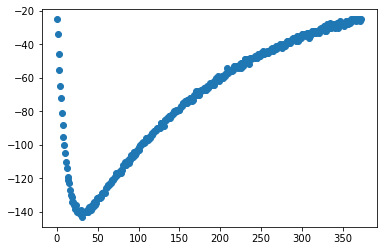

new event captured! Event Counter: 2
The experiment duration is now up to 610.5639641284943 seconds!
retrieved 212 data points from the FIFO!


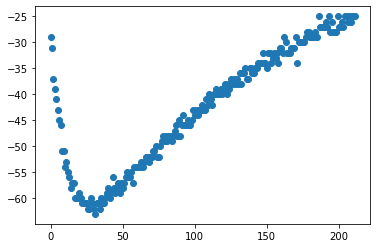

new event captured! Event Counter: 3
The experiment duration is now up to 691.0456008911133 seconds!
retrieved 644 data points from the FIFO!


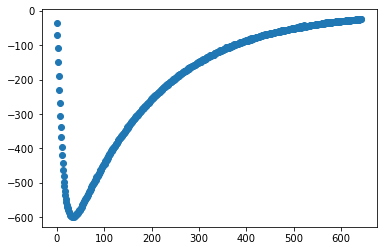

new event captured! Event Counter: 4
The experiment duration is now up to 734.6499791145325 seconds!
retrieved 384 data points from the FIFO!


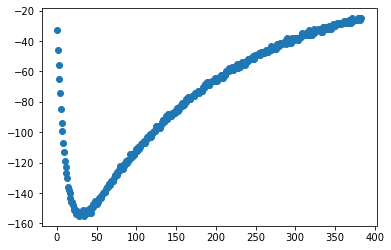

new event captured! Event Counter: 5
The experiment duration is now up to 870.3029141426086 seconds!
retrieved 194 data points from the FIFO!


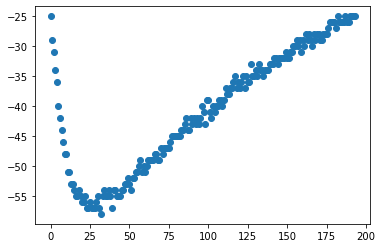

new event captured! Event Counter: 6
The experiment duration is now up to 968.1532890796661 seconds!
retrieved 643 data points from the FIFO!


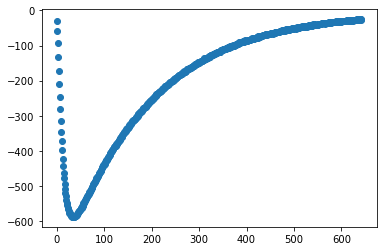

new event captured! Event Counter: 7
The experiment duration is now up to 1056.8577494621277 seconds!
retrieved 760 data points from the FIFO!


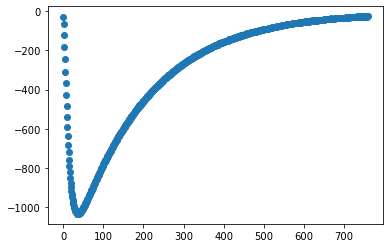

new event captured! Event Counter: 8
The experiment duration is now up to 1116.338522195816 seconds!
retrieved 179 data points from the FIFO!


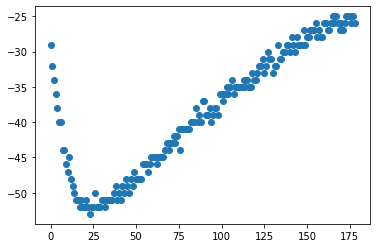

new event captured! Event Counter: 9
The experiment duration is now up to 1441.6401724815369 seconds!
retrieved 532 data points from the FIFO!


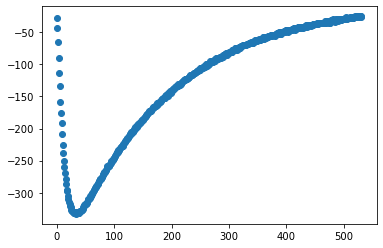

new event captured! Event Counter: 10
The experiment duration is now up to 1472.9027318954468 seconds!
retrieved 896 data points from the FIFO!


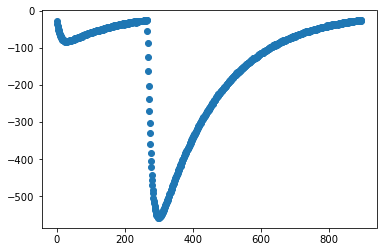

new event captured! Event Counter: 11
The experiment duration is now up to 1479.6630902290344 seconds!
retrieved 494 data points from the FIFO!


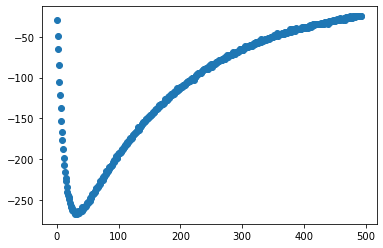

new event captured! Event Counter: 12
The experiment duration is now up to 1794.2369437217712 seconds!
retrieved 383 data points from the FIFO!


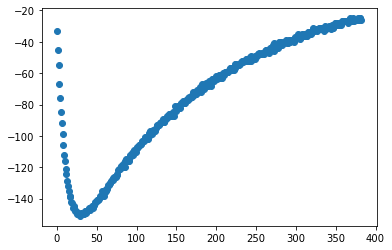

new event captured! Event Counter: 13
The experiment duration is now up to 2040.0555448532104 seconds!
retrieved 622 data points from the FIFO!


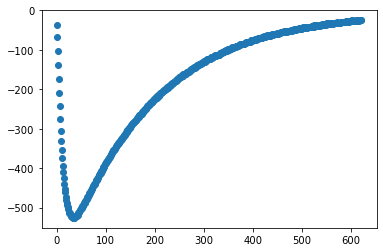

new event captured! Event Counter: 14
The experiment duration is now up to 2055.0153527259827 seconds!
retrieved 361 data points from the FIFO!


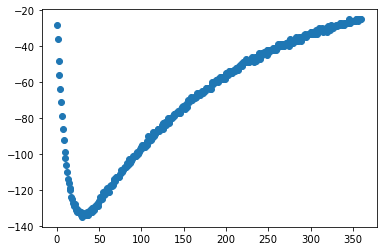

new event captured! Event Counter: 15
The experiment duration is now up to 2168.7404129505157 seconds!
retrieved 367 data points from the FIFO!


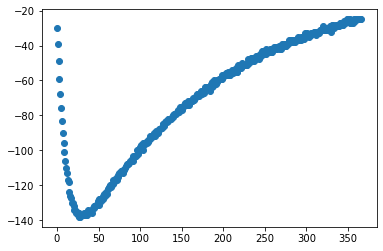

new event captured! Event Counter: 16
The experiment duration is now up to 2615.602653026581 seconds!
retrieved 184 data points from the FIFO!


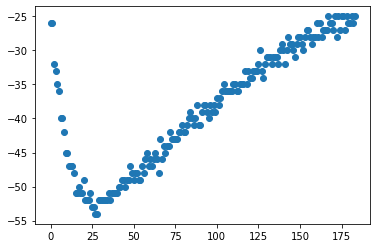

new event captured! Event Counter: 17
The experiment duration is now up to 3264.0659375190735 seconds!
retrieved 397 data points from the FIFO!


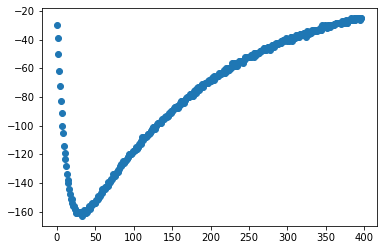

new event captured! Event Counter: 18
The experiment duration is now up to 3284.929838180542 seconds!
retrieved 293 data points from the FIFO!


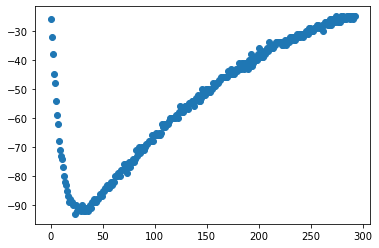

new event captured! Event Counter: 19
The experiment duration is now up to 3424.309239387512 seconds!
retrieved 399 data points from the FIFO!


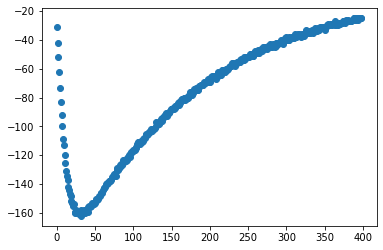

new event captured! Event Counter: 20
The experiment duration is now up to 3427.598459482193 seconds!
retrieved 365 data points from the FIFO!


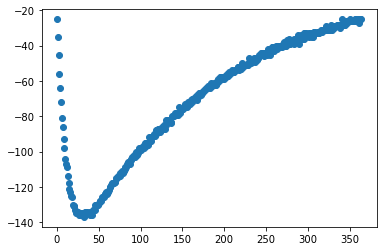

In [14]:
#run a fixed time experiment
fixed_time_experiment(n_seconds=3600, threshold=0b111111100111, threshold_direction=1)